In [6]:
import pandas as pd
import pedpy
import matplotlib.pyplot as plt
import glob
import os

In [7]:
def extract_category_from_filename(filename: str) -> str:
    """
    Extracts the category part from a given filename, taking into account
    special cases like 'mix_sorted' and 'mix_random'.
    The category is extracted based on its position in the filename, which is
    assumed to follow the pattern: '../data/country/category_restOfTheFilename.csv'.
    Parameters:
    - filename (str): The full path of the file.

    Returns:
    - str: The extracted category.
    """
    # Extract the basename of the file (e.g., 'female_41_21.csv')
    basename = os.path.basename(filename)

    # Split by underscores and reconstruct the category part
    parts = basename.split('_')
    if parts[0].startswith("mix"):
        # Handles 'mix_sorted' and 'mix_random'
        category = "_".join(parts[:2])
    else:
        # Handles 'female', 'male', etc.
        category = parts[0]

    return category


In [8]:
rename_mapping = {
    "ID": "id",
    "t(s)": "time",
    "x(m)": "x",
    "y(m)": "y",
}
column_types = {
    "id": int,
    "gender": int,
    "time": float,
    "x": float,
    "y": float,
}
countries = [
    "aus",
    "ger",
    "jap",
    "chn",
    "pal",
]
files = {}
for country in countries:
    files[country] = glob.glob(f"../data/{country}/*.csv")


def load_file(filename: str) -> pedpy.TrajectoryData:
    def calculate_fps(data: pd.DataFrame) -> int:
        """Calculate fps based on the mean difference of the 'time' column."""
        mean_diff = data.groupby("id")["time"].diff().dropna().mean()
        return int(round(1 / mean_diff))

    def set_column_types(data: pd.DataFrame, col_types) -> pd.DataFrame:
        """Set the types of the dataframe columns based on the given column types."""
        # Ensure columns are in data before type casting
        valid_types = {
            col: dtype for col, dtype in col_types.items() if col in data.columns
        }
        return data.astype(valid_types)

    data = pd.read_csv(filename)
    data.rename(columns=rename_mapping, inplace=True)
    data = set_column_types(data, column_types)
    fps = calculate_fps(data)
    return pedpy.TrajectoryData(data=data, frame_rate=fps)

In [9]:
csv_file = "../app_data/proximity_analysis_results_euc.csv"
euc = pd.read_csv(csv_file)

## Plot distance vs N in 4 different subfigures per type

In [37]:
def plot_distance_comparison_by_type(df, country, output_pdf, method):
    """
    Plot distance comparison by type for a given country and save the plot to a PDF file.

    Parameters:
    - df: DataFrame containing the data.
    - country: The country to filter the data by.
    - output_pdf: The path to save the output PDF file.
    """
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
    fig.suptitle(f'Distance Comparison per Type for {country.title()}')

    types = sorted(df["type"].unique())
    for i, type_ in enumerate(types):
        # Extract 'N' values directly within the loop to avoid unnecessary DataFrame operations
        df_filtered = df[(df["country"] == country) & (df["type"] == type_)].copy()

        df_filtered['N'] = df_filtered['file'].str.extract(r'_(\d+)_').astype(int)
        Nsf = sorted(df_filtered['N'].dropna().unique())
        Ns = [int(N) for N in Nsf]
        means_diff = []
        stds_diff = []
        means_same = []
        stds_same = []

        for N in Ns:
            # Filter by 'N' without creating a new DataFrame
            df_n = df_filtered[df_filtered['N'] == N]
            print(N, type_)
            print(df_n["same_gender_proximity_next"].min(),df_n["same_gender_proximity_next"].max())
            # Calculate means and stds directly
            mean_diff = df_n["diff_gender_proximity_next"].mean()
            std_diff = df_n["diff_gender_proximity_next"].std()
            mean_same = df_n["same_gender_proximity_next"].mean()
            std_same = df_n["same_gender_proximity_next"].std()

            means_diff.append(mean_diff)
            stds_diff.append(std_diff)
            means_same.append(mean_same)
            stds_same.append(std_same)

        # Plotting
        axs[i].errorbar(Ns, means_diff, yerr=stds_diff, label='Diff', fmt='--x')
        axs[i].errorbar(Ns, means_same, yerr=stds_same, label='Same', fmt='-o')
        axs[i].set_title(type_)
        axs[i].set_xlabel('N', fontsize=14)
        axs[i].grid(alpha=0.6)
        if i == 0:
            axs[i].set_ylabel('Distance / m', fontsize=14)
        #axs[i].set_ylim(0, 6)

    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(output_pdf)
    plt.show()

4 female
1.1158825789481617 5.293600221021607
8 female
0.7969977666217133 4.5050068690291685
16 female
0.4521494664378142 1.3186402276587803
20 female
0.3163438793465112 1.503629744983784
24 female
0.3218842338481331 1.4865394209370968
32 female
0.1691362172924534 0.9641676202818682
36 female
0.097986172493878 1.233225303827326
40 female
0.0588357884284726 0.8199410039752862
4 male
1.2354164075322938 5.277753045567782
8 male
0.6483486253552174 5.438268785192583
15 male
0.4715167865516562 1.617400791393401
16 male
0.4919335829154168 1.8168052317185792
19 male
0.3825802530188926 1.4809102774982694
20 male
0.3329841587823661 1.55401705267349
27 male
0.2478170696299995 1.0801156419569156
31 male
0.2209163642648501 1.171025473676811
35 male
0.189770519312142 0.9851681683854792
4 mix_random
1.2958145739263778 5.327894738074318
8 mix_random
0.7271496819775144 4.405997968678606
16 mix_random
0.442308591370325 2.1391430994676357
20 mix_random
0.3781204702208016 1.3464696988792582
24 mix_random


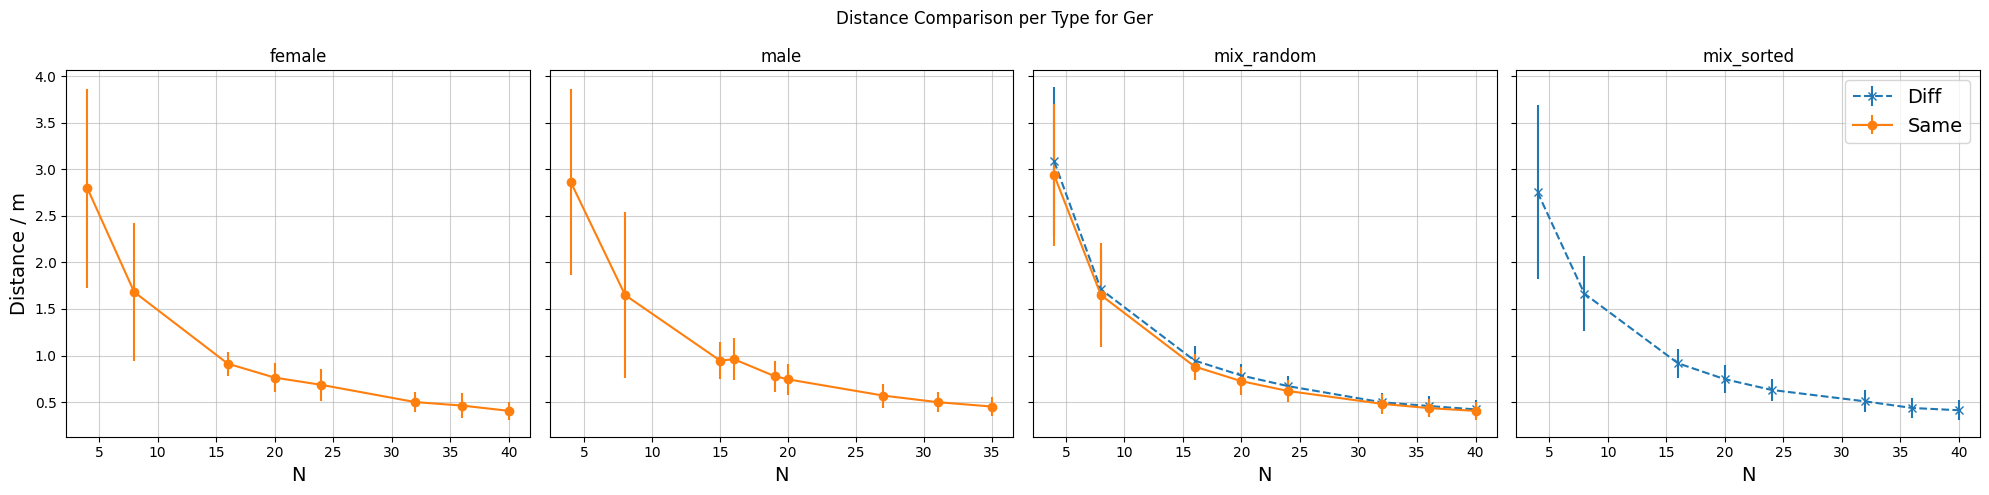

In [38]:
for country in ["ger"]:#["pal", "chn", "ger", "aus", "jap"]:
    figname = f'proximity/distance_type_density_{country}_linear.pdf'
    plot_distance_comparison_by_type(euc, country, figname, "linear")

## Plot distance vs N in ONE figure per type

In [39]:
def plot_distance_comparison_single_figure(df, country, output_pdf, method):
    """
    Plot distance comparison for all types in a single figure for a given country and save the plot to a PDF file.

    Parameters:
    - df: DataFrame containing the data.
    - country: The country to filter the data by.
    - output_pdf: The path to save the output PDF file.
    """
    plt.figure(figsize=(6, 6))
    #plt.title(f'Distance Comparison Across Types for {country.title()}')
    ext_length = 17.475005503226413
    types = sorted(df["type"].unique())
    markers = ['o', 's', '^', 'D', '*']  # Example markers for differentiation
    line_styles = ['-', '--', '-.', ':', '-']  # Example line styles for differentiation

    for i, type_ in enumerate(types):
        df_filtered = df[(df["country"] == country) & (df["type"] == type_)].copy()
        df_filtered['N'] = df_filtered['file'].str.extract(r'_(\d+)_').astype(int)
        Ns = sorted(df_filtered['N'].dropna().unique())

        means_diff = []
        stds_diff = []
        means_same = []
        stds_same = []

        for N in Ns:
            df_n = df_filtered[df_filtered['N'] == N]
            df_n.loc[:, "diff_gender_proximity_next"] /= (ext_length/N)
            df_n.loc[:, "same_gender_proximity_next"] /= (ext_length/N)
            mean_diff = df_n["diff_gender_proximity_next"].mean()
            std_diff = df_n["diff_gender_proximity_next"].std()
            mean_same = df_n["same_gender_proximity_next"].mean()
            std_same = df_n["same_gender_proximity_next"].std()

            means_diff.append(mean_diff)
            stds_diff.append(std_diff)
            means_same.append(mean_same)
            stds_same.append(std_same)

        # Plotting with error bars, using different markers/lines for each type
        if type_ not in ["female", "male"]:
            plt.errorbar(Ns, means_diff, yerr=stds_diff, label=f'{type_} diff', fmt=markers[i], linestyle=line_styles[i])
        if type_ not in ["mix_sorted"]:
            plt.errorbar(Ns, means_same, yerr=stds_same, label=f'{type_} same', fmt=markers[i], linestyle=line_styles[i])

    plt.xlabel('N', fontsize=14)
    plt.ylabel('Distance / m', fontsize=14)
    plt.ylim(0, 2)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    plt.legend(fontsize=13, ncol=2)
    plt.tick_params(axis="both", which="major", labelsize=12)

    plt.tight_layout()
    print(output_pdf)
    plt.savefig(output_pdf)
    plt.show()


proximity/distance_comparison_single_figure_pal_euc.pdf


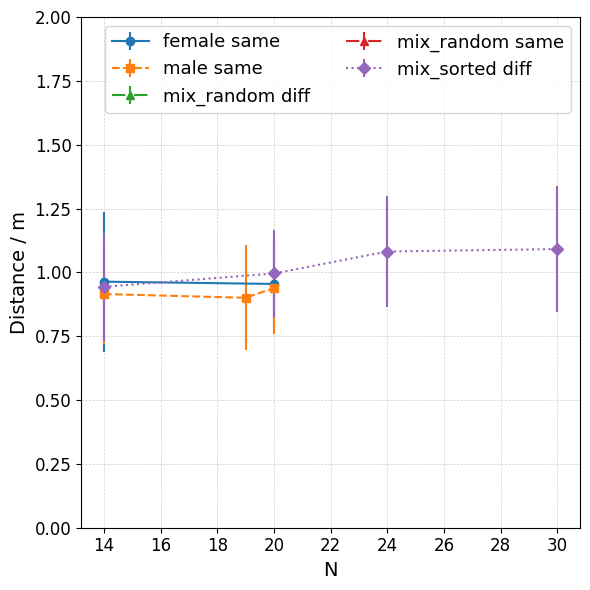

proximity/distance_comparison_single_figure_chn_euc.pdf


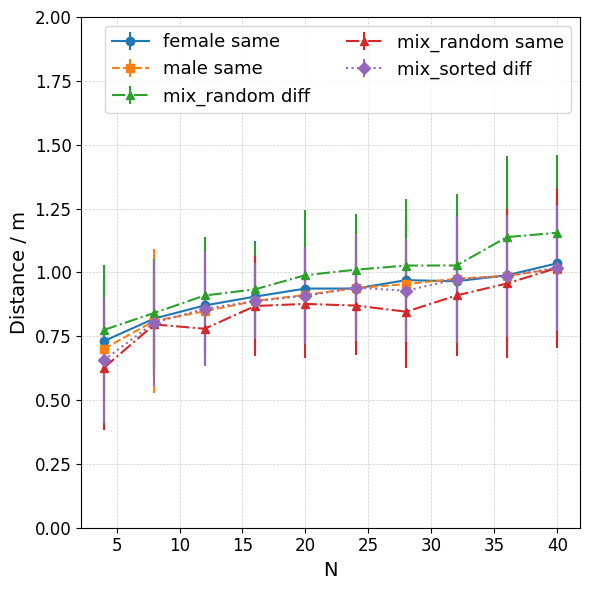

proximity/distance_comparison_single_figure_ger_euc.pdf


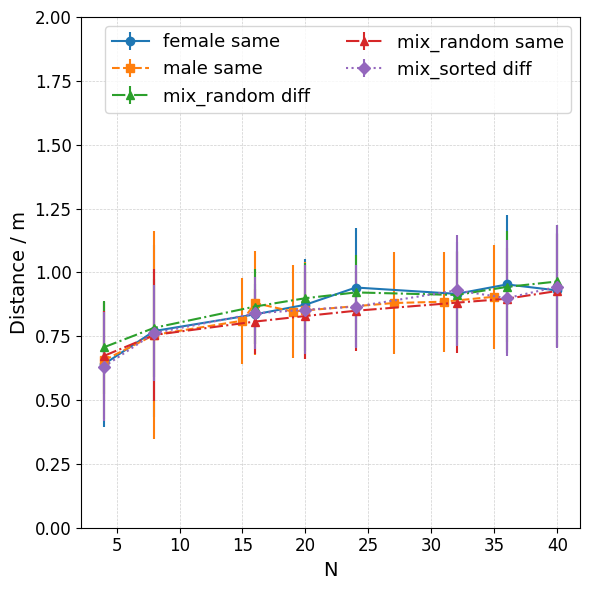

proximity/distance_comparison_single_figure_aus_euc.pdf


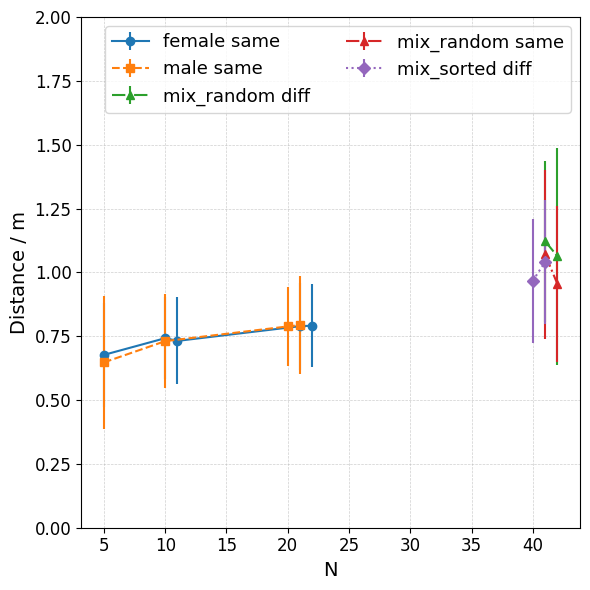

proximity/distance_comparison_single_figure_jap_euc.pdf


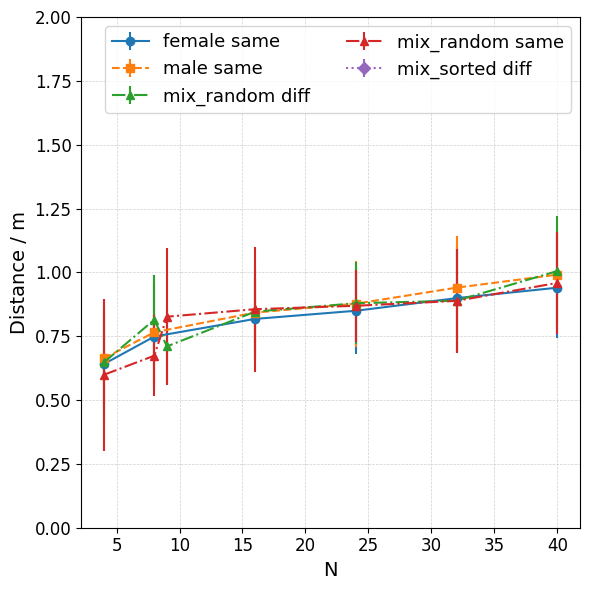

In [40]:
methods = ["euc"]#, "arc"]
#fig, axs = plt.subplots(1, 5, figsize=(10, 5)) # 1 row, 2 columns
for method in methods:
    if method == "euc":
        df = euc.copy( )
    #if method == "arc":
    #    df = arc.copy()

    for i, country in enumerate(["pal", "chn", "ger", "aus", "jap"]):
        figname = f'proximity/distance_comparison_single_figure_{country}_{method}.pdf'
        plot_distance_comparison_single_figure(df, country, figname, method)